# Processing Oscilloscope Point Scan

The samples from our oscilloscope connected to our microphone (since our sound card doesn't support going up to 28kHz) will be useful for visualizing the acoustics of our system.
We will have to know beforehand which frequency we want to detect.
This depends on the oscilloscope settings, especially the resolution of the FFT when calculating that on the scope.

In [1]:
import os
import pickle
import glob
import skimage
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

## Data Loading

### Format

This function loads in the data.
The data should be in the format

```bash
data_dir/<x_coord>_<y_coord>_<z_coord>.pkl
```

To make the design more modular we pass in the folder name to the function.
Each pickle file should be a numpy array with dimensions $N \times D$, where $N$ is the number of samples collected at the point and $D$ is the dimension of the FFT data.
Therefore, you can also provide a `sample_start` and `sample_end` to filter out the unneeded data.

### Example

For example, a lot of my initial scans had the following parameters.

1. I set the oscilloscope to do a fourier transform with a resolution of $5$ Hz for each frequency bin.
2. The tranducer is outputting $28$ kHz from a sine wave.
3. When measuring with the `OscilloscopeMicrophone` class, I started sampling the FFT data from $0$ Hz to $50000$ Hz.

Therefore, for `sample_start` and `sample_end` I should put $5595$ and $5605$ respectively, so I can look closely at the fourier transform from between $27975$ Hz and $28025$ Hz.
I recommend giving a range of a few Hz even if you are measuring a pure tone because sometimes the FFT may smear.

In [2]:
def get_data(data_dir, sample_start=0, sample_end=200, verbose=False):
    fnames = list(sorted(glob.glob(os.path.join(data_dir, "*.pkl"))))
    
    print('Found %s records' % len(fnames))
    # Load into a list of tuples of xmin, xmax, y, data
    data = []
    XMIN, XMAX = None, None
    for fname in fnames:
        with open(fname, 'rb') as f:
            fft_data = pickle.load(f)

        # Isolate the frequency. In our case, 28kHz is usually around sample 8000 to 10000
        try:
            amplitudes = fft_data[:, sample_start:sample_end]
        except IndexError:
            if verbose:
                print("indexerror for file %s" % fname)
                print('Diagonstics on the length of each sample:')
            lengths = [len(arr) for arr in fft_data]
            correct_length = min(lengths)
            amplitudes = np.array([t[:correct_length] for t in fft_data]) 
            
            
        name = os.path.basename(fname).replace('.pkl', '').replace('continuous_', '')
        coords = [float(coord) for coord in name.split('_')]
        xmin, xmax, y = coords
        XMIN = xmin
        XMAX = xmax
        data.append((xmin, xmax, y, amplitudes))
        
    # Sort by y coordinate (xmin and xmax are expected to be the same for all)
    data = list(sorted(data))
    if not data:
        raise RuntimeError('No Data Found')
    
    return data

We also know that the transducer is being fed in a pure sine wave from the signal generator, so we expect a sharp spike at one specific frequency in the fourier transform.
Therefore, we will get the sample have a function that returns the indices and values of the maximum values in each FFT sample.
We also have a function that returns just the maximum amplitude found in your range.

In [3]:
def get_maxes_and_freqs(samples):
    """Takes in a N by S array, where N is the number of samples and S is the
    dimensions of the FFT sample taken. We will get a list of maxes and the
    frequency they correspond to as two np arrays, so we can plot as a scatterplot"""
    maxes = samples.max(axis=1)
    idxs = samples.argmax(axis=1)
    return idxs, maxes

In [4]:
def get_max_amp(samples):
    """Takes in a N by S array, where N is the number of samples and S is the
    dimensions of the FFT sample taken. Gets the maximum amplitude of each sample,
    and then takes the average of the maximum amplitude over all the samples."""
    return samples.max(axis=1).mean()

Now we can actually get the data from a scan that I did previously.

In [5]:
data = get_data('../data/1551236003')

Found 2601 records


### Data Output Format

Using Python, we've loaded the data as a list of tuples.
We use this format:

```bash
[(x_coord, y_coord, z_coord, ARR)]
```

where `ARR` is the numpy array of `NUM_SAMPLES x REDUCED_FFT_DIM`, where `REDUCED_FFT_DIM` was how much you reduced the FFT bins by supplying `sample_start` and `sample_end`.

In [6]:
data

[(0.0, 0.0, 0.0, array([[  5.,  13.,  12., ..., -10., -10., -11.],
         [  5.,  13.,  12., ..., -10., -10., -11.],
         [  8.,  14.,  12., ..., -41., -28., -15.],
         ...,
         [  5.,  12.,  12., ..., -28., -26., -23.],
         [  8.,  14.,  13., ..., -14., -15., -15.],
         [  5.,  12.,  12., ..., -31., -29., -28.]])),
 (0.0, 2.0, 0.0, array([[  5.,  13.,  12., ..., -10., -10., -11.],
         [  5.,  13.,  12., ..., -10., -10., -11.],
         [  8.,  14.,  12., ..., -41., -28., -15.],
         ...,
         [  5.,  12.,  12., ..., -28., -26., -23.],
         [  8.,  14.,  13., ..., -14., -15., -15.],
         [  5.,  12.,  12., ..., -31., -29., -28.]])),
 (0.0, 4.0, 0.0, array([[  4.,  12.,  13., ..., -25., -22., -19.],
         [  4.,  12.,  13., ..., -25., -22., -19.],
         [ 24.,  26.,  25., ...,  37.,  38.,  38.],
         ...,
         [-11.,   8.,  11., ..., -11., -12., -12.],
         [ -6.,   9.,  12., ..., -21., -18., -15.],
         [ -8.,   8.,  

Now we can plot the data by processing layers for each XY plane.
If we looked at the numbers from data, we see that this scan is just scanning a box from (0, 0) to (100, 100) with a resolution of 2.

In [7]:
# For each frequency bin, we can make an image of what values we have.
# otherwise, make that value -1 or something to show that we don't have info
WIDTH, HEIGHT = 51, 51
image = np.zeros((WIDTH, HEIGHT))

for index, d in enumerate(data):
    idx, idy = int(index % WIDTH), int(index / WIDTH)
    _, max_amps = get_maxes_and_freqs(d[-1])
    image[idx, idy] = max_amps.mean()

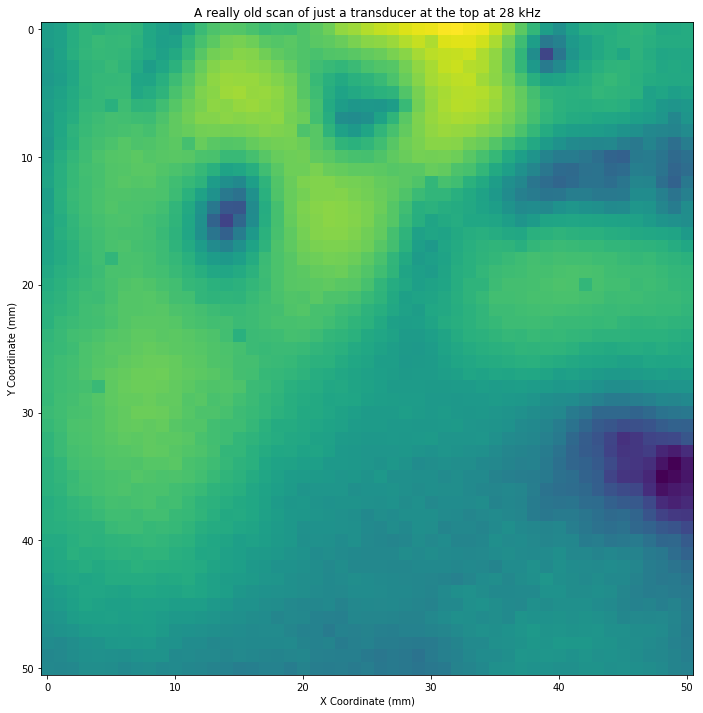

In [8]:
plt.figure(figsize=(12, 12))
plt.title("A really old scan of just a transducer at the top at 28 kHz")
plt.xlabel("X Coordinate (mm)")
plt.ylabel("Y Coordinate (mm)")
plt.imshow(image)
plt.show()

### Increasing the Resolution

That image was pretty underwhelming, especially noting that the resolution was so poor, I don't even know what's going on.
Here's another example of a completely different scan.


This time let's actually look at what our samples look like.
We'll take everything we have recorded and plot a pickle file.

In [51]:
data = get_data('../data/1544186931', sample_start=0, sample_end=100000)

Found 5776 records


In [52]:
print("Shape of each pickle file.")
print(data[0][-1].shape)

Shape of each pickle file.
(7, 5000)


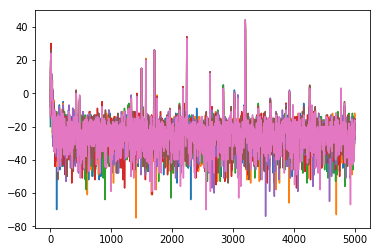

In [53]:
plt.plot(data[0][-1].T)
plt.show()

As we can see, the peak we want is probably the ones between bins 3000 and 4000.
I think the peak near 2000 is probably artifacting.
Let's reload our data.

In [54]:
data = get_data('../data/1544186931', sample_start=0, sample_end=100000)

Found 5776 records


In [55]:
# For each frequency bin, we can make an image of what values we have.
# otherwise, make that value -1 or something to show that we don't have info
WIDTH, HEIGHT = 76, 76
image = np.zeros((WIDTH, HEIGHT))

for index, d in enumerate(data):
    idx, idy = int(index % WIDTH), int(index / WIDTH)
    image[idx, idy] = get_max_amp(d[-1])

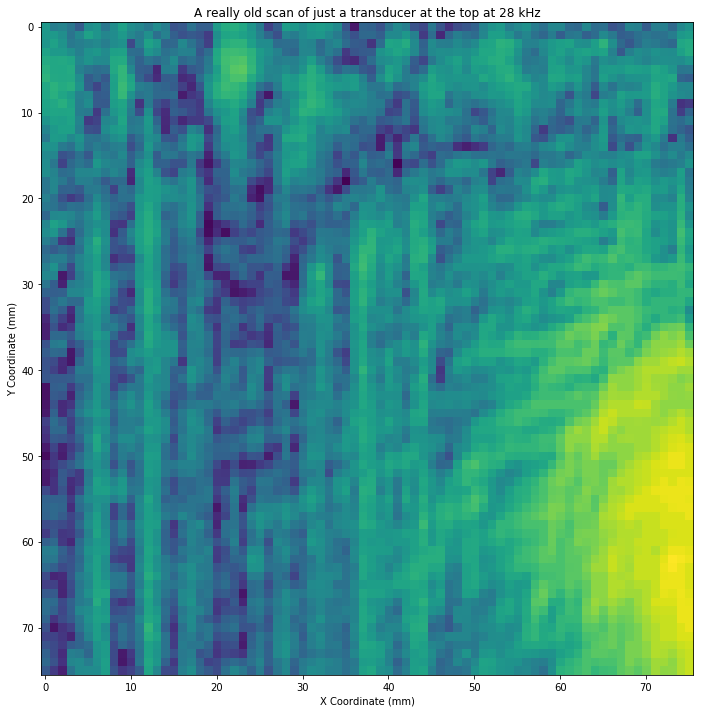

In [50]:
plt.figure(figsize=(12, 12))
plt.title("A really old scan of just a transducer at the top at 28 kHz")
plt.xlabel("X Coordinate (mm)")
plt.ylabel("Y Coordinate (mm)")
plt.imshow(image)
plt.show()

We see that in this case, we get much better resolution of the transducer and can actually see waves.
We can verify that the wavelengths agree with 28 kHz through an air medium.